Preprocessing and feature engineering

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [3]:
#Load the dataset
df1 = pd.read_csv("smmh.csv")

In [4]:
df1.shape

(481, 21)

In [5]:
# Make a working copy
df = df1.copy()

In [6]:
# Drop rows with missing values
df_clean = df.dropna()

In [7]:
#print columns: remove timestamp not important

In [14]:
# Drop irrelevant columns (like Timestamp)
df_clean = df_clean.drop(columns=['Timestamp'])

In [16]:
# check the value counts in the Gender column using this line of code:
df_clean['2. Gender'].value_counts()

2. Gender
Female                 245
Male                   201
Nonbinary                1
Non-binary               1
unsure                   1
Non binary               1
There are others???      1
Name: count, dtype: int64

Since only "Male" and "Female" have a meaningful count, and the rest (like "Nonbinary", "unsure", etc.) appear only once, you can simplify this column into two main groups:

In [19]:
# Keep only Male and Female, drop others
df_clean = df_clean[df_clean['2. Gender'].isin(['Male', 'Female'])]
print(df_clean['2. Gender'].value_counts())

2. Gender
Female    245
Male      201
Name: count, dtype: int64


In [21]:
# Encode as binary: Male = 1, Female = 0
df_clean['Gender_binary'] = df_clean['2. Gender'].map({'Male': 1, 'Female': 0})

In [23]:
df_clean = df_clean.drop(columns=['2. Gender'])

In [25]:
df_clean['3. Relationship Status'].value_counts()

3. Relationship Status
Single               261
Married               94
In a relationship     85
Divorced               6
Name: count, dtype: int64

In [27]:
#function to do one hot coding

In [29]:
# Step 1: Define allowed categories
allowed_relationships = ['Single', 'Married', 'In a relationship']

# Step 2: Filter rows where 'Relationship Status' is one of the allowed values
df_clean = df_clean[df_clean['3. Relationship Status'].isin(allowed_relationships)]

In [31]:
# Apply one-hot encoding to '3. Relationship Status'
df_clean = pd.get_dummies(df_clean, columns=['3. Relationship Status'], drop_first=True)

In [33]:
# Convert True/False to 1/0 for relationship status columns
df_clean[['3. Relationship Status_Married', '3. Relationship Status_Single']] = \
    df_clean[['3. Relationship Status_Married', '3. Relationship Status_Single']].astype(int)


In [35]:
df_clean['4. Occupation Status'].value_counts()

4. Occupation Status
University Student    277
Salaried Worker       118
School Student         42
Retired                 3
Name: count, dtype: int64

dropping Retired due to low count

In [38]:
# Drop "Retired" from Occupation
# Filter out rows where occupation is 'Retired'
df_clean = df_clean[df_clean['4. Occupation Status'] != 'Retired']

In [40]:
# Apply one-hot encoding
df_clean = pd.get_dummies(df_clean, columns=['4. Occupation Status'], drop_first=True)

In [42]:
# Convert boolean True/False to integer 1/0 for occupation columns
occupation_cols = [col for col in df_clean.columns if '4. Occupation Status_' in col]
df_clean[occupation_cols] = df_clean[occupation_cols].astype(int)

In [44]:
df_clean['5. What type of organizations are you affiliated with?'].value_counts()

5. What type of organizations are you affiliated with?
University                        236
Private                            54
School                             41
Company                            29
University, Company                19
University, Private                16
School, University                  9
Company, Private                    7
Goverment                           5
University, Company, Private        5
School, University, Private         4
University, N/A                     3
University, Goverment               2
School, Company                     2
School, N/A                         2
University, Goverment, Private      1
School, Private                     1
University, Company, Goverment      1
Name: count, dtype: int64

In [46]:
# Clean whitespace and split multiple affiliations
df_clean['5. What type of organizations are you affiliated with?'] = \
    df_clean['5. What type of organizations are you affiliated with?'].fillna('').apply(lambda x: [i.strip() for i in x.split(',')])

# Use MultiLabelBinarizer
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# Transform the multi-label column
affiliation_dummies = pd.DataFrame(
    mlb.fit_transform(df_clean['5. What type of organizations are you affiliated with?']),
    columns=['Aff_' + col for col in mlb.classes_],
    index=df_clean.index
)

# Concatenate with original DataFrame
df_clean = pd.concat([df_clean.drop(columns=['5. What type of organizations are you affiliated with?']), affiliation_dummies], axis=1)


In [48]:
# Check unique values
df_clean['6. Do you use social media?'].value_counts()

6. Do you use social media?
Yes    435
No       2
Name: count, dtype: int64

In [50]:
df_clean['6. Do you use social media?'] = df_clean['6. Do you use social media?'].map({'Yes': 1, 'No': 0})

In [52]:
df_clean['7. What social media platforms do you commonly use?'].value_counts()

7. What social media platforms do you commonly use?
Facebook, Instagram, YouTube                                                 31
Facebook, YouTube                                                            27
Facebook, Instagram, YouTube, Snapchat                                       24
Facebook, Instagram, YouTube, Discord                                        18
Facebook                                                                     17
                                                                             ..
Facebook, Discord, Reddit                                                     1
Instagram, Discord, Reddit, Pinterest, TikTok                                 1
Twitter, Instagram, YouTube, Snapchat, Discord, Reddit, Pinterest, TikTok     1
Facebook, YouTube, Snapchat                                                   1
Instagram, YouTube, Snapchat, Discord, Reddit, Pinterest, TikTok              1
Name: count, Length: 121, dtype: int64

In [54]:
# Create dummy variables for top platforms
platforms = ['Instagram', 'Facebook', 'Twitter', 'Snapchat', 'YouTube']

for platform in platforms:
    df_clean[f'platform_{platform}'] = df_clean['7. What social media platforms do you commonly use?']\
                                        .str.contains(platform, case=False, na=False).astype(int)


In [56]:
#Drop the original column (optional)
df_clean.drop(columns=['7. What social media platforms do you commonly use?'], inplace=True)


In [58]:
# Check unique values
df_clean['8. What is the average time you spend on social media every day?'].value_counts()

8. What is the average time you spend on social media every day?
More than 5 hours        107
Between 2 and 3 hours     92
Between 3 and 4 hours     85
Between 1 and 2 hours     62
Between 4 and 5 hours     61
Less than an Hour         30
Name: count, dtype: int64

In [60]:
time_mapping = {
    'Less than an Hour': 0.5,
    'Between 1 and 2 hours': 1.5,
    'Between 2 and 3 hours': 2.5,
    'Between 3 and 4 hours': 3.5,
    'Between 4 and 5 hours': 4.5,
    'More than 5 hours': 6
}


In [62]:
#Code to Apply the Mapping:
df_clean['8. What is the average time you spend on social media every day?'] = \
    df_clean['8. What is the average time you spend on social media every day?'].map(time_mapping)


In [64]:
# Check how many entries fall into each mapped category
print(df_clean['8. What is the average time you spend on social media every day?'].value_counts().sort_index())


8. What is the average time you spend on social media every day?
0.5     30
1.5     62
2.5     92
3.5     85
4.5     61
6.0    107
Name: count, dtype: int64


In [66]:
df_clean.columns.tolist()

['1. What is your age?',
 '6. Do you use social media?',
 '8. What is the average time you spend on social media every day?',
 '9. How often do you find yourself using Social media without a specific purpose?',
 '10. How often do you get distracted by Social media when you are busy doing something?',
 "11. Do you feel restless if you haven't used Social media in a while?",
 '12. On a scale of 1 to 5, how easily distracted are you?',
 '13. On a scale of 1 to 5, how much are you bothered by worries?',
 '14. Do you find it difficult to concentrate on things?',
 '15. On a scale of 1-5, how often do you compare yourself to other successful people through the use of social media?',
 '16. Following the previous question, how do you feel about these comparisons, generally speaking?',
 '17. How often do you look to seek validation from features of social media?',
 '18. How often do you feel depressed or down?',
 '19. On a scale of 1 to 5, how frequently does your interest in daily activities fl

In [68]:
# df_clean['depression_binary'] = df_clean['18. How often do you feel depressed or down?'].apply(lambda x: 1 if x >= 3 else 0)

In [70]:
# # Save final cleaned and preprocessed dataset to CSV
# df_clean.to_csv("smmh_final_clean.csv", index=False)

In [73]:
# Assume df_clean is your cleaned and feature-engineered DataFrame
# and 'depression_binary' is your target variable

# # Step 1: Reorder columns to move target to the end
# other_columns = [col for col in df_clean.columns if col != 'depression_binary']
# df_clean = df_clean[other_columns + ['depression_binary']]

# Step 2: Save to CSV
df_clean.to_csv("smmh_final_model_ready.csv", index=False)
print("Reordered and saved as 'smmh_final_model_ready.csv'")


Reordered and saved as 'smmh_final_model_ready.csv'


In [75]:
df_clean.columns

Index(['1. What is your age?', '6. Do you use social media?',
       '8. What is the average time you spend on social media every day?',
       '9. How often do you find yourself using Social media without a specific purpose?',
       '10. How often do you get distracted by Social media when you are busy doing something?',
       '11. Do you feel restless if you haven't used Social media in a while?',
       '12. On a scale of 1 to 5, how easily distracted are you?',
       '13. On a scale of 1 to 5, how much are you bothered by worries?',
       '14. Do you find it difficult to concentrate on things?',
       '15. On a scale of 1-5, how often do you compare yourself to other successful people through the use of social media?',
       '16. Following the previous question, how do you feel about these comparisons, generally speaking?',
       '17. How often do you look to seek validation from features of social media?',
       '18. How often do you feel depressed or down?',
       '19. O

In [94]:
# ------------------ Step 1: Save T-Test Results Table ------------------

import pandas as pd

# Define T-Test Results
results_data = {
    'Mental_Health_Question': [
        '18. How often do you feel depressed or down?',
        '14. Do you find it difficult to concentrate on things?',
        '13. On a scale of 1 to 5, how much are you bothered by worries?',
        '15. On a scale of 1-5, how often do you compare yourself to other successful people through the use of social media?',
        '11. Do you feel restless if you haven\'t used Social media in a while?',
        '20. On a scale of 1 to 5, how often do you face issues regarding sleep?',
        '17. How often do you look to seek validation from features of social media?',
        '19. On a scale of 1 to 5, how frequently does your interest in daily activities fluctuate?',
        '16. Following the previous question, how do you feel about these comparisons, generally speaking?'
    ],
    'Best_P_Value': [0.0144, 0.0162, 0.0192, 0.0604, 0.0650, 0.0927, 0.1003, 0.1872, 0.3087]
}

# Create DataFrame
results_df = pd.DataFrame(results_data)

# Sort by Best_P_Value ascending
results_df = results_df.sort_values(by='Best_P_Value').reset_index(drop=True)

# Save the table as CSV
results_df.to_csv('TTest_Results.csv', index=False)

# Display nicely
from IPython.display import display
display(results_df.style.background_gradient(cmap='Blues').format({"Best_P_Value": "{:.4f}"}))

print("✅ T-Test results saved successfully as 'TTest_Results.csv'")


,Mental_Health_Question,Best_P_Value
0,18. How often do you feel depressed or down?,0.0144
1,14. Do you find it difficult to concentrate on things?,0.0162
2,"13. On a scale of 1 to 5, how much are you bothered by worries?",0.0192
3,"15. On a scale of 1-5, how often do you compare yourself to other successful people through the use of social media?",0.0604
4,11. Do you feel restless if you haven't used Social media in a while?,0.0650
5,"20. On a scale of 1 to 5, how often do you face issues regarding sleep?",0.0927
6,17. How often do you look to seek validation from features of social media?,0.1003
7,"19. On a scale of 1 to 5, how frequently does your interest in daily activities fluctuate?",0.1872
8,"16. Following the previous question, how do you feel about these comparisons, generally speaking?",0.3087


✅ T-Test results saved successfully as 'TTest_Results.csv'


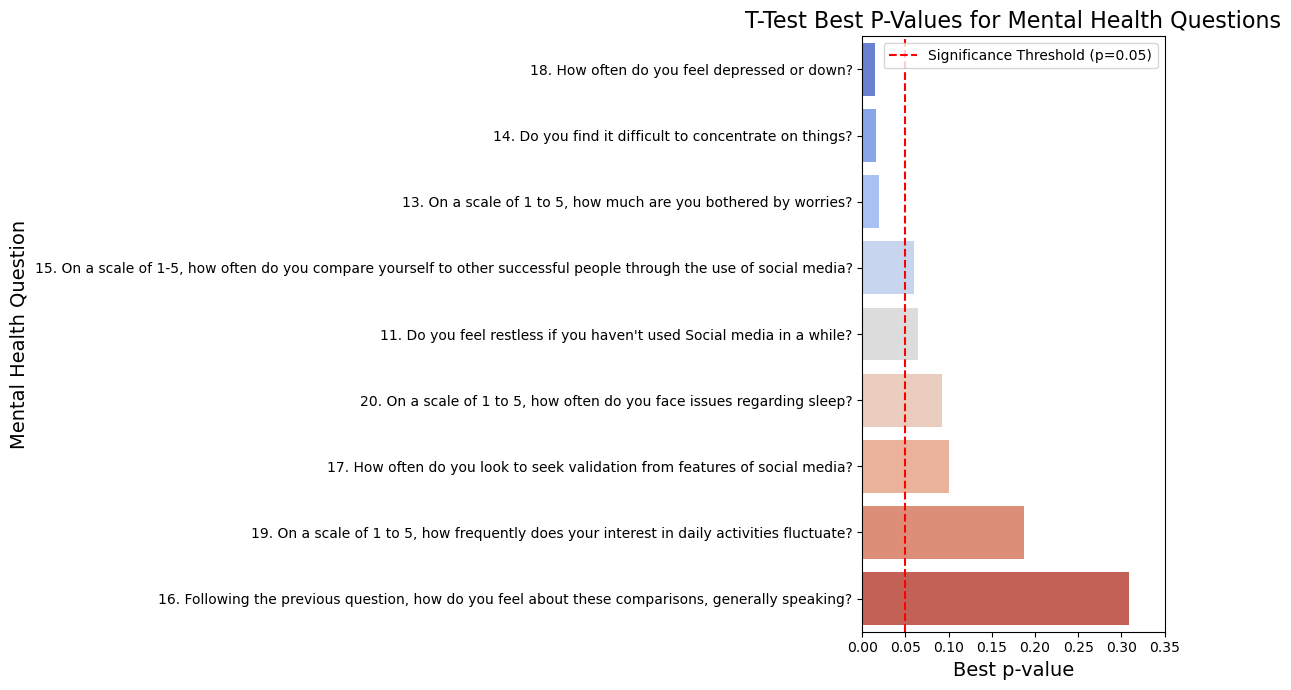

✅ T-Test P-Value Bar Plot saved successfully as 'TTest_PValue_Barplot.png'


In [96]:
# ------------------ Step 2: Save T-Test Bar Plot ------------------

import matplotlib.pyplot as plt
import seaborn as sns

# Create Bar Plot
plt.figure(figsize=(12, 7))
sns.barplot(
    x='Best_P_Value',
    y='Mental_Health_Question',
    data=results_df,
    palette='coolwarm'
)

# Add red line for significance threshold
plt.axvline(x=0.05, color='red', linestyle='--', label='Significance Threshold (p=0.05)')

# Titles and labels
plt.title("T-Test Best P-Values for Mental Health Questions", fontsize=16)
plt.xlabel("Best p-value", fontsize=14)
plt.xlim(0, 0.35)
plt.ylabel("Mental Health Question", fontsize=14)
plt.legend()

# Clean layout
plt.tight_layout()

# Save the plot
plt.savefig('TTest_PValue_Barplot.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

print("✅ T-Test P-Value Bar Plot saved successfully as 'TTest_PValue_Barplot.png'")
